In [35]:
import time
import torch
import torch.nn as nn
import numpy as np
import random
from torch import optim
import matplotlib.pyplot as plt
from typing import List
from utils import *
from torch.utils.data import Dataset, DataLoader, RandomSampler
import tqdm
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [36]:
class TransformerLayer(nn.Module):
    def __init__(self, d_model, d_internal):
        """
        :param d_model: The dimension of the inputs and outputs of the layer (note that the inputs and outputs
        have to be the same size for the residual connection to work)
        :param d_internal: The "internal" dimension used in the self-attention computation. Your keys and queries
        should both be of this length.
        """
        super().__init__()
        """
        self.W_Q = torch.tensor(np.random.random([d_model, d_internal]), dtype=torch.float64)
        self.W_K = torch.tensor(np.random.random([d_model, d_internal]), dtype=torch.float64)
        self.W_V = torch.tensor(np.random.random([d_model, d_model]), dtype=torch.float64)
        """
        self.W_Q = torch.nn.Linear(d_model, d_internal, False)
        self.W_K = torch.nn.Linear(d_model, d_internal, False)
        self.W_V = torch.nn.Linear(d_model, d_model, False)

        self.SoftMax = torch.nn.Softmax(dim=-1)

        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_internal),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(d_internal, d_model)
        )
        self.d_model = d_model
        self.d_internal = d_internal

        self.double()


        #raise Exception("Implement me")

    def forward(self, input_vecs):
        """
        Q = torch.matmul( input_vecs, self.W_Q)
        K = torch.matmul(input_vecs, self.W_K)
        V = torch.matmul(input_vecs, self.W_V )
        """
        Q = self.W_Q(input_vecs)
        K = self.W_K(input_vecs)
        V = self.W_V(input_vecs)


  
        Q = torch.matmul(Q, torch.transpose(K, -2, -1))

        Q = Q / torch.sqrt(torch.tensor(self.d_model)) 
        Attn = self.SoftMax(Q)
        a = torch.matmul(Attn, V)

        a = a + input_vecs

        output = self.FFN(a) + a

        
        return output, Attn

        raise Exception("Implement me")


# Implementation of positional encoding that you can use in your network
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, num_positions: int=20, batched=False):
        """
        :param d_model: dimensionality of the embedding layer to your model; since the position encodings are being
        added to character encodings, these need to match (and will match the dimension of the subsequent Transformer
        layer inputs/outputs)
        :param num_positions: the number of positions that need to be encoded; the maximum sequence length this
        module will see
        :param batched: True if you are using batching, False otherwise
        """
        super().__init__()
        # Dict size
        self.emb = nn.Embedding(num_positions, d_model)
        self.batched = batched
        self.d_model = d_model
        self.num_positions = num_positions

        self.sinu = torch.zeros((num_positions, d_model)).to(DEVICE)

        for pos in range(num_positions):
            for m in range(d_model):
                if m%2 == 0:
                    self.sinu[pos][m] += torch.sin(torch.tensor(pos/(10000**((2*m)/d_model))))
                else:
                    self.sinu[pos][m] += torch.cos(torch.tensor(pos/(10000**((2*m)/d_model))))

        #self.sinu = torch.tensor(self.sinu)

    # def change_np(self, np):
    #     if np == self.num_positions:
    #         return
        
    #     self.num_positions = np
    #     self.sinu = torch.zeros((np, self.d_model))
    #     for pos in range(self.num_positions):
    #         for m in range(self.d_model):
    #             if m%2 == 0:
    #                 self.sinu[pos][m] += torch.sin(torch.tensor(pos/(10000**((2*m)/self.d_model))))
    #             else:
    #                 self.sinu[pos][m] += torch.cos(torch.tensor(pos/(10000**((2*m)/self.d_model))))

    def forward(self, x):
        """
        :param x: If using batching, should be [batch size, seq len, embedding dim]. Otherwise, [seq len, embedding dim]
        :return: a tensor of the same size with positional embeddings added in
        """

        # Second-to-last dimension will always be sequence length
        # input_size = x.shape[-2]
        # indices_to_embed = torch.tensor(np.asarray(range(0, input_size))).type(torch.LongTensor)
        if self.batched:
            # Use unsqueeze to form a [1, seq len, embedding dim] tensor -- broadcasting will ensure that this
            # gets added correctly across the batch

            for b in range(x.shape[0]):
                x[b] += self.sinu
            return x 
        else:
            return x + self.sinu


TODO: test with various positional embeddings

In [37]:
class LetterCountingExample(object):
    def __init__(self, input: str, output: np.array, vocab_index: Indexer):
        self.input = input
        self.input_indexed = np.array([vocab_index.index_of(ci) for ci in input])
        self.input_tensor = torch.LongTensor(self.input_indexed)
        self.output = output
        self.output_tensor = torch.LongTensor(self.output)


class Transformer(nn.Module):
    def __init__(self, vocab_size, num_positions, d_model, d_internal, num_classes, num_layers, **args):
        """
        :param vocab_size: vocabulary size of the embedding layer
        :param num_positions: max sequence length that will be fed to the model; should be 20
        :param d_model: see TransformerLayer
        :param d_internal: see TransformerLayer
        :param num_classes: number of classes predicted at the output layer; should be 3
        :param num_layers: number of TransformerLayers to use; can be whatever you want
        """ 
        super().__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.d_internal = d_internal
        

        #self.tformer = []
        #for i in range(num_layers):
        #    self.tformer.append(TransformerLayer(d_model, d_internal))

        self.tformer = TransformerLayer(d_model, d_internal)
        #self.tformer1 = TransformerLayer(d_model, d_internal)
        self.Softmax = torch.nn.LogSoftmax(dim=-1)
        self.FFN = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_internal),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(d_internal, num_classes)
        )
        self.b = False
        self.penc = PositionalEncoding(d_model=d_model, num_positions=num_positions, batched=self.b)
        self.embed = torch.nn.Embedding(vocab_size, d_model)

        self.double()

        #raise Exception("Implement me")

    def extrap(self, model, method='double'):
        if method == 'double':
            d_m = self.d_model
            d_i = d_m // 2 # = self.d_internal
            z = torch.zeros(d_m, d_i, dtype=float)
            j = 0

            for i in range(0, d_m-1, 2):
                z[i][j] = 1
                z[i+1][j] = 1
                j += 1

            z1 = torch.zeros(d_i, d_i//2, dtype=float)
            j = 0
            for i in range(0, d_i-1, 2):    
                z1[i][j] = 1
                z1[i+1][j] = 1
                j += 1

            Q = torch.matmul(z, torch.transpose(model.tformer.W_Q.weight.data, -1, -2))
            Q = torch.matmul(Q, torch.transpose(z1, -1,-2))
            self.tformer.W_Q.weight.data = torch.transpose(Q, -1, -2)

            K = torch.matmul(z, torch.transpose(model.tformer.W_K.weight.data, -1, -2))
            K = torch.matmul(z1, torch.transpose(K, -1, -2))
            self.tformer.W_K.weight.data = K

            V = torch.matmul(z, torch.transpose(model.tformer.W_V.weight.data, -1, -2))
            V = torch.matmul(z, torch.transpose(V,-1,-2))
            self.tformer.W_V.weight.data = torch.transpose(V, -1, -2)

        if method == 'onehot':
            # for one hot we simply add the corresponding one hot vector to the dimensions of the vector

            Q = model.tformer.W_Q.weight.data
            z = torch.zeros((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            Q = torch.cat((Q,z), dim=0)
            z = torch.zeros((self.d_model - model.d_model, self.d_model - model.d_model)).to(DEVICE)
            # z = torch.randn((self.d_model - model.d_model, self.d_model - model.d_model)).to(DEVICE)
            Q = torch.cat((Q,z), dim=-1)
            for i in range(self.d_internal):
                Q[i][i] = 1 if Q[i][i] == 0 else Q[i][i]
            

            V = model.tformer.W_V.weight.data
            z = torch.zeros((self.d_model - model.d_model, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.d_model - model.d_model, model.tformer.d_model)).to(DEVICE)
            V = torch.cat((V,z), dim=0)
            z = torch.zeros((self.d_model, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.d_model, model.tformer.d_model)).to(DEVICE)
            V = torch.cat((V,z), dim=-1)
            for i in range(self.d_model):
                V[i][i] = 1 if V[i][i] == 0 else V[i][i]

            K = model.tformer.W_K.weight.data
            z = torch.zeros((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.d_internal - model.d_internal, model.tformer.d_model)).to(DEVICE)
            K = torch.cat((K,z), dim=0)
            z = torch.zeros((self.tformer.d_internal, model.tformer.d_model)).to(DEVICE)
            # z = torch.randn((self.tformer.d_internal, model.tformer.d_model)).to(DEVICE)
            K = torch.cat((K,z), dim=-1)
            for i in range(self.d_internal):
                K[i][i] = 1 if K[i][i] == 0 else K[i][i]


            self.tformer.W_Q.weight.data = Q
            self.tformer.W_K.weight.data = K
            self.tformer.W_V.weight.data = V



    def forward(self, indices):
        """

        :param indices: list of input indices
        :return: A tuple of the softmax log probabilities (should be a 20x3 matrix) and a list of the attention
        maps you use in your layers (can be variable length, but each should be a 20x20 matrix)
        """
        t = self.embed(indices)
        t = self.penc(t)
        t = t.to(torch.float64)
        t, attn = self.tformer(t)
        #t1, attn = self.tformer1(t) 
        #t = t1 + t
        x = self.FFN(t)
        x = self.Softmax(x)
        #print(x.shape)
        #exit()
        return x, [attn]
    
    def batch(self, b):
        self.b = b
        self.penc.batched = b

In [38]:
def get_letter_count_output(input: str, count_only_previous: bool=True) -> np.array:
    """
    :param input: The string
    :param count_only_previous: True if we should only count previous occurrences, False for all occurrences
    :return: the output for the letter-counting task as a numpy array of 0s, 1s, and 2s
    """
    output = np.zeros(len(input))
    for i in range(0, len(input)):
        if count_only_previous:
            output[i] = min(2, len([c for c in input[0:i] if c == input[i]]))
        else:
            output[i] = min(2, len([c for c in input if c == input[i]]) - 1)  # count all *other* instances of input[i]
    return output

In [39]:
def read_example(file):
    """
    :param file:
    :return: A list of the lines in the file, each exactly 20 characters long
    """
    all_lines = []
    for line in open(file):
        all_lines.append(line[:-1]) # eat the \n
    
    #print("%i lines read in" % len(all_lines))
    return all_lines


In [40]:
class SentenceData(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self.data = data
        self.labels = labels
        self.n = len(self.data)

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return (self.data[idx], self.labels[idx])

In [41]:
def decode(model: Transformer, dev_examples: List[LetterCountingExample], do_print=False, do_plot_attn=False):
    """
    Decodes the given dataset, does plotting and printing of examples, and prints the final accuracy.
    :param model: your Transformer that returns log probabilities at each position in the input
    :param dev_examples: the list of LetterCountingExample
    :param do_print: True if you want to print the input/gold/predictions for the examples, false otherwise
    :param do_plot_attn: True if you want to write out plots for each example, false otherwise
    :return:
    """
    num_correct = 0
    num_total = 0
    if len(dev_examples) > 100:
        if do_print:
            print("Decoding on a large number of examples (%i); not printing or plotting" % len(dev_examples))
        do_print = False
        do_plot_attn = False
    for i in range(0, len(dev_examples)):
        ex = dev_examples[i]
        (log_probs, attn_maps) = model.forward(ex.input_tensor.to(DEVICE))
        predictions = np.argmax(log_probs.cpu().detach().numpy(), axis=1)
        if do_print:
            print("INPUT %i: %s" % (i, ex.input))
            print("GOLD %i: %s" % (i, repr(ex.output.astype(dtype=int))))
            print("PRED %i: %s" % (i, repr(predictions)))
        if do_plot_attn:
            for j in range(0, len(attn_maps)):
                attn_map = attn_maps[j]
                fig, ax = plt.subplots()
                im = ax.imshow(attn_map.detach().numpy(), cmap='hot', interpolation='nearest')
                ax.set_xticks(np.arange(len(ex.input)), labels=ex.input)
                ax.set_yticks(np.arange(len(ex.input)), labels=ex.input)
                ax.xaxis.tick_top()
                # plt.show()
                plt.savefig("plots/%i_attns%i.png" % (i, j))
        acc = sum([predictions[i] == ex.output[i] for i in range(0, len(predictions))])
        num_correct += acc
        num_total += len(predictions)
    if do_print:
        print("Accuracy: %i / %i = %f" % (num_correct, num_total, float(num_correct) / num_total))
    return (num_correct, num_total, float(num_correct) / num_total)


In [42]:
def train_classifier(args, train:LetterCountingExample, dev:LetterCountingExample, extrap=None, num_epochs=10):

    model = Transformer(**args)
    if extrap != None:
        model.extrap(extrap, method='onehot')

    model.to(DEVICE)

    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=16, shuffle=True)

    training_loop(model, data, num_epochs)


def training_loop(model, data, dev, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    results = []
    avg_loss = []
    for t in range(num_epochs):
        loss_fnc = nn.NLLLoss()
        model.train()
        l = 0.
        for i, (d, label) in enumerate(data):
            py, x = model(d)
            loss = loss_fnc(py.view(-1,3), label.view(-1))

            model.zero_grad()
            loss.backward()
            optimizer.step()
            l += loss.item()
             
        r = decode(model, dev)

        # print("epoch {}:\t".format(t), decode(model, dev))

        avg_loss.append(l/len(data))
        model.eval()
        results.append(r[-1])
    
    model.train()
    return model, results, avg_loss

In [43]:
def test(args, model=None, train_data='data/lettercounting-train.txt', dev_data='data/lettercounting-dev.txt', do_print=False, do_plot_attn=False, num_epochs=10):
    # Constructs the vocabulary: lowercase letters a to z and space
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_examples(train_data)
    train_bundles = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_examples(dev_data)
    dev_bundles = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]
    if model == None:
        model = train_classifier(args, train_bundles, dev_bundles, num_epochs=num_epochs)
    else:
        model = train_classifier(args, train_bundles, dev_bundles, extrap=model, num_epochs=num_epochs)

    results = []
    # Decodes the first 5 dev examples to display as output
    results.append(decode(model, dev_bundles[0:5], do_print=do_print, do_plot_attn=do_plot_attn))
    # Decodes 100 training examples and the entire dev set (1000 examples)
    if do_print:
        print("Training accuracy (whole set):")
    results.append(decode(model, train_bundles, do_print))

    if do_print:
        print("Dev accuracy (whole set):")
    results.append(decode(model, dev_bundles, do_print))
    
    return model, results


In [44]:
def average_on_axis(arr:List[List]):
    n = len(arr)
    avg = np.zeros(len(arr[0]))
    for row in arr:
        avg += np.array(row)
    return avg/n

In [49]:
def compare(model_args:List):
    vocab = [chr(ord('a') + i) for i in range(0, 26)] + [' ']
    vocab_index = Indexer()
    train_data='data/lettercounting-train.txt' 
    dev_data='data/lettercounting-dev.txt'
    do_print=False
    do_plot_attn=False
    num_epochs=10
    for char in vocab:
        vocab_index.add_and_get_index(char)
    if do_print:
        print(repr(vocab_index))

    count_only_previous = True

    # Constructs and labels the data
    train_exs = read_example(train_data)
    train = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in train_exs]
    dev_exs = read_example(dev_data)
    dev = [LetterCountingExample(l, get_letter_count_output(l, count_only_previous), vocab_index) for l in dev_exs]   

    x_train = []
    y_train = []

    for i in range(len(train)):
        x_train.append(train[i].input_tensor.to(DEVICE))
        y_train.append(train[i].output_tensor.to(DEVICE))

    ds = SentenceData(x_train, y_train)

    data = DataLoader(ds, batch_size=128, shuffle=True)
    prev_args = None
    num_training_epochs = 50
    transfer_ratio = 0.4

    axis_numbers = np.array([i for i in range(num_training_epochs)])

    for args in model_args:
        if prev_args == None:   
            prev_args = args
            continue
        res_std = []
        res_tran = []
        pprev_args = []
        transfer_train = []
        full_train = []
        transfer_full_train = []
        
        loss1 = []
        loss2 = []
        loss3 = []
        loss4 = []
        
        for t in tqdm.tqdm(range(25)):
        # for t in range(10):
            model = Transformer(**prev_args).to(DEVICE)
            model, r1, l1 = training_loop(model, data, dev, num_epochs=int(num_training_epochs*transfer_ratio))
            pprev_args.append(r1)
            loss1.append(l1)

            model_transfer = Transformer(**args).to(DEVICE)
            model_transfer.extrap(model, method='onehot')
            model_transfer, r2, l2 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs - int(num_training_epochs*transfer_ratio))
            res_tran.append(np.max(r2))
            res_tran.append(decode(model_transfer, dev)[-1])
            transfer_train.append(r2)
            loss2.append(l2)

            model_full = Transformer(**args).to(DEVICE)
            m, r3, l3 = training_loop(model_full, data, dev, num_epochs=num_training_epochs)
            res_std.append(decode(model_full, dev, do_print, do_plot_attn)[-1])
            res_tran.append(np.max(r3))
            res_tran.append(decode(m, dev)[-1])
            full_train.append(r3)
            loss3.append(l3)

            model_transfer = Transformer(**args).to(DEVICE)
            model_transfer.extrap(model, method='onehot')
            model_transfer, r4, l4 = training_loop(model_transfer, data, dev, num_epochs=num_training_epochs)
            transfer_full_train.append(r4)
            loss4.append(l4)

        
        pprev_args = average_on_axis(pprev_args)
        transfer_train = average_on_axis(transfer_train)
        full_train = average_on_axis(full_train)
        transfer_full_train = average_on_axis(transfer_full_train)

        loss1 = average_on_axis(loss1)
        loss2 = average_on_axis(loss2)
        loss3 = average_on_axis(loss3)
        loss4 = average_on_axis(loss4)


        prev_args = args

        print("args: ", args)
        
        print("transfer: \t {}\tstd: {}".format(np.average(res_tran), np.std(res_tran)))
        # print(np.max(res_tran))
        print("full train: \t{}\tstd: {}".format(np.average(res_std), np.std(res_std)))
        # print(np.max(res_std))
        t_stat, p_val = ttest_ind(res_tran, res_std)
        print("p-value:", p_val)

        if p_val < 0.05:
            print("Statistically significant difference between models (p-value =", p_val, ")")
        else:
            print("No statistically significant difference between models (p-value =", p_val, ")")
        # Calculate the effect size
        effect_size = np.mean(res_tran) - np.mean(res_std)
        print("Effect size:", effect_size)
        effect_size = effect_size / np.sqrt((np.std(res_tran)**2 + np.std(res_std)**2)/2)
        print("Effect size (Cohen's d):", effect_size)



        # plotting accuracy across training epochs
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, full_train, label="Full training")
        ax.plot(axis_numbers, np.concatenate((pprev_args, transfer_train)), label='small model transfer')
        ax.plot(axis_numbers, transfer_full_train, label='transfer full train')
        ax.legend()
        ax.set_title("Learning Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Dev set accuracy")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        plt.savefig("images/acc_model_{}.png".format(args['d_model']))
        
        # LOSS
        fig, ax = plt.subplots()
        
        ax.plot(axis_numbers, loss3, label="Full training")
        ax.plot(axis_numbers, np.concatenate((loss1, loss2)), label='small model transfer')
        ax.plot(axis_numbers, loss4, label='transfer full train')
        ax.legend()
        ax.set_title("Loss Rate Comparison (model size {})".format(args['d_model']))
        plt.ylabel("Training Loss")
        plt.xlabel("Training Epochs")
        plt.grid()
        plt.show()
        plt.savefig("images/loss_model_{}.png".format(args['d_model']))
        # print(args)
        # print(results)
        print() 

In [50]:
def do_pca(models:List):
    Qs = []
    Ks = []
    Vs = []
    for model in models:
        Qs.append(model.tformer.W_Q.weight.data.detach().numpy())
        Ks.append(model.tformer.W_K.weight.data.detach())
        Vs.append(model.tformer.W_V.weight.data.detach())
        # self.tformer.W_Q.weight.data = torch.transpose(Q, -1, -2)
    
    n = np.array(Qs).shape
    print(np.array(Qs).shape)

    pca = PCA(n_components=5, svd_solver='full')
    pca.fit(Qs[-1])
    print(pca.explained_variance_)
    print(pca.singular_values_)
    U, S, Vh = LA.svd(Qs[-1])
    # print(U)
    print(S[:12])
    # print(Vh)
    print()

In [51]:
def eigen_comparison(model_args:List):
    # compare the pca of a school of models of the same size

    models = []   
    for args in model_args:
        models.append([])
        for _ in range(1):
            m, r = test(args=args)
            models[-1].append(m)
            print(r)
        do_pca(models[-1])

CUDA Device used:  cuda


100%|██████████| 25/25 [1:18:57<00:00, 189.51s/it]

args:  {'vocab_size': 27, 'num_positions': 20, 'd_model': 192, 'd_internal': 96, 'num_classes': 3, 'num_layers': 1}
transfer: 	 0.9178585000000001	std: 0.045636122236119056
full train: 	0.889984	std: 0.048206677379798744
p-value: 0.008399693119301426
Statistically significant difference between models (p-value = 0.008399693119301426 )
Effect size: 0.027874500000000135
Effect size (Cohen's d): 0.5938452063980778


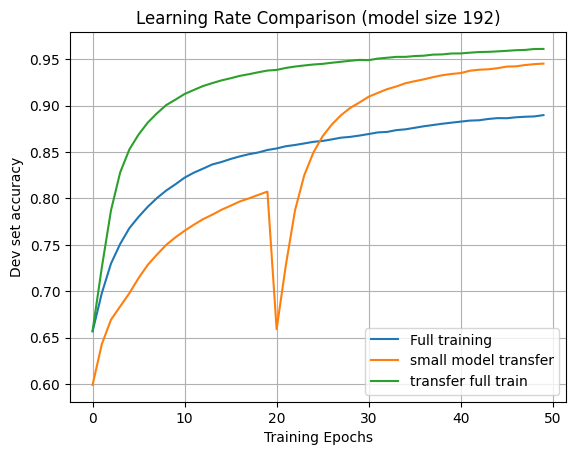

<Figure size 640x480 with 0 Axes>

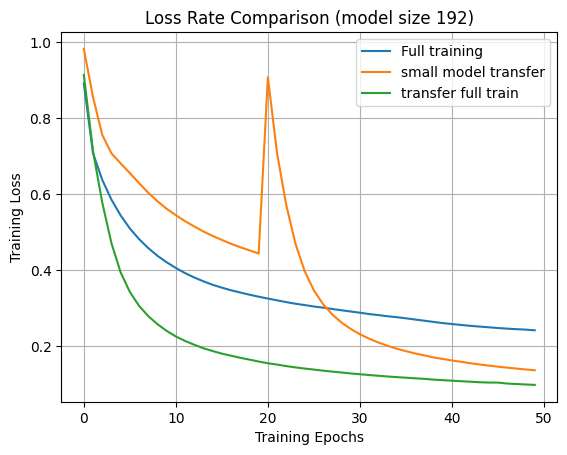

  0%|          | 0/25 [00:00<?, ?it/s]

In [52]:
model_args = [
    # {'vocab_size':27, 'num_positions':20, 'd_model':24, 'd_internal':12, 'num_classes':3, 'num_layers':1},    # these two model sizes are too small to transfer information
    # {'vocab_size':27, 'num_positions':20, 'd_model':48, 'd_internal':24, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':96, 'd_internal':48, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':192, 'd_internal':96, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':384, 'd_internal':192, 'num_classes':3, 'num_layers':1},
    {'vocab_size':27, 'num_positions':20, 'd_model':768, 'd_internal':384, 'num_classes':3, 'num_layers':1},
]
print("CUDA Device used: ", DEVICE)
compare(model_args)
# eigen_comparison(model_args)